/home/adrian/anaconda2/envs/novdet/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


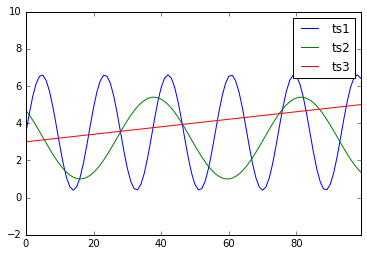

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import sqrt

# generate 100 point in betwween 0 and 50
x=np.linspace(start=0,stop=50,num=100)
ts1_fast=pd.Series(3.1*np.sin(x/1.5)+3.5)
ts2_slow=pd.Series(2.2*np.sin(x/3.5+2.4)+3.2)
ts3_line=pd.Series(0.04*x+3.0)

ts1_fast.plot()
ts2_slow.plot()
ts3_line.plot()

plt.ylim(-2,10)
plt.legend(['ts1','ts2','ts3'])
plt.show()

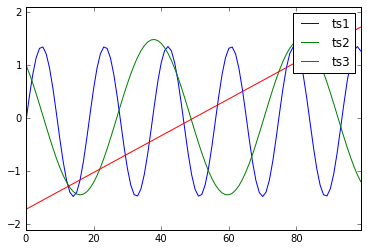

In [21]:
from sklearn.preprocessing import scale
def scale_mean_std(ts):
    # Normalization (scaling)
    # scale(X, axis=0, with_mean=True, with_std=True, copy=True)
    # Axis of normalization (if 0) normalize each feature.

    # reshape as column ndarrays for scaling - Note that axis=0 requires that the serie be in a column
    tsr = scale(ts.reshape(-1, 1), axis=0, with_mean=True, with_std=True, copy=True)
    # reshape the single column of the ndarrays into a pandas series for plotting
    return pd.Series(tsr[:,0])  

ts1 = scale_mean_std(ts1_fast)
ts2 = scale_mean_std(ts2_slow)
ts3 = scale_mean_std(ts3_line)

# plotting with Pandas
ts1.plot()
ts2.plot()
ts3.plot()
plt.ylim(-2.1,2.1)
plt.legend(['ts1','ts2','ts3'])
plt.show()

In [3]:
def euclid_dist(t1,t2):
    return sqrt(sum((t1-t2)**2))

In [4]:
print euclid_dist(ts1_fast,ts2_slow)
print euclid_dist(ts1_fast,ts3_line)

26.959216038
23.1892491903


In [5]:
print euclid_dist(ts1,ts2)
print euclid_dist(ts1,ts3)

14.1036307
14.3633965976


## Dynamic Time Warping

construct an n×n matrix whose i,jth element is the Euclidean distance between qi and cj. 

We want to find a path through this matrix that minimizes the cumulative distance. Specifically a path from the start point (0, 0) (top, left) to the end point (n, n) (bottom, right).

This path then determines the optimal alignment between the two time series. It should be noted that it is possible for one point in a time series to be mapped to multiple points in the other time series.

In [6]:
def DTWDistance(s1, s2):
    """
    Note that this is not a recursive function, so it is not implementing memoization.
    It is iterative, so it is implementing bottom-up Dynamic Programming, (tabulation).
    The min() function calling DTW[(i-1, j)] always finds a value in that cell because 
    it was processes in the previous iteration, the cells are evaluated in the righ order."""
    
    DTW={}
    
    # Matrix representation
    # We are too cool for ndarrays so we will pass from Numpy and use a dictionary with tuples as keys instead.
    for i in range(len(s1)):
        DTW[(i, -1)] = float('inf')
    for i in range(len(s2)):
        DTW[(-1, i)] = float('inf')
    DTW[(-1, -1)] = 0

    for i in range(len(s1)):
        for j in range(len(s2)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [7]:
print DTWDistance(ts1_fast,ts2_slow)

17.9297184686


In [8]:
print DTWDistance(ts1_fast,ts3_line)

21.5494948244


In [9]:
def DTWDistance2(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [10]:
print DTWDistance2(ts1_fast,ts2_slow, 10)

18.5965518384


In [11]:
print DTWDistance2(ts1_fast,ts3_line, 10)

22.4724828468


The distances with Distance2 are a bit higher because the optimization is not so perfect so we don't find the absolute minimum path.'

In [12]:
def LB_Keogh(s1,s2,r):
    """
    r: is a ratio of a range of search for th min or max in the second serie
    """
    LB_sum=0
    for i, s1_value in enumerate(s1):
        # lower bound is just the min of s2 in the range [i-r : i+r]
        s2_lower_bound=min(s2[(i-r if i-r>=0 else 0):(i+r)])

        
        # upper bound is just the max of s2 in the range [i-r : i+r]
        s2_upper_bound=max(s2[(i-r if i-r>=0 else 0):(i+r)])
        
        # only add to the distance if the s1 point is 
        # outside the range between lower and upper bounds of s2
        if s1_value>s2_upper_bound:
            LB_sum += (s1_value-s2_upper_bound)**2   
        elif s1_value<s2_lower_bound:
            LB_sum += (s1_value-s2_lower_bound)**2
    
    return sqrt(LB_sum)

In [13]:
print 'ts1_fast vs ts2_slow: ', LB_Keogh(ts1_fast,ts2_slow, 20)
print 'ts1_fast vs ts3_line:', LB_Keogh(ts1_fast,ts3_line, 20)
print 'ts1 vs ts2:', LB_Keogh(ts1,ts2, 20)
print 'ts1 vs ts3:', LB_Keogh(ts1,ts3, 20)

ts1_fast vs ts2_slow:  6.25389235159
ts1_fast vs ts3_line: 19.9595478694
ts1 vs ts2: 0.649167135722
ts1 vs ts3: 9.3500204781


In [16]:
# DTW library (BEST Library)
from dtw import dtw
def tsw_dist(ts1, ts2, k):
    dist, cost, acc, path = dtw(ts1, ts2, dist=lambda x, y: np.linalg.norm(x - y))
    return dist

print 'ts1_fast vs ts2_slow: ', tsw_dist(ts1_fast,ts2_slow, 20)
print 'ts1_fast vs ts3_line:', tsw_dist(ts1_fast,ts3_line, 20)
print 'ts1 vs ts2:', tsw_dist(ts1,ts2, 20)
print 'ts1 vs ts3:', tsw_dist(ts1,ts3, 20)

ts1_fast vs ts2_slow:  0.722553600541
ts1_fast vs ts3_line: 1.0141154945
ts1 vs ts2: 0.295372861031
ts1 vs ts3: 0.502136515679


In [17]:
# fastDTW library
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw

def fasttsw_dist(ts1, ts2, k):
    dist, path = fastdtw(ts1, ts2, dist=euclidean)
    return dist

print 'ts1_fast vs ts2_slow: ', fasttsw_dist(ts1_fast,ts2_slow, 20)
print 'ts1_fast vs ts3_line:', fasttsw_dist(ts1_fast,ts3_line, 20)
print 'ts1 vs ts2:', fasttsw_dist(ts1,ts2, 20)
print 'ts1 vs ts3:', fasttsw_dist(ts1,ts3, 20)

ts1_fast vs ts2_slow:  197.316283236
ts1_fast vs ts3_line: 207.499469882
ts1 vs ts2: 106.86550566
ts1 vs ts3: 122.024550107
